# Evaluating the low-rank Gaussian embeddings

This notebook shows you how to evaluate Gaussian embeddings that were pre-trained from a graph induced from the Cellular Component (CC) of the [GO](http://geneontology.org/). Here, they are evaluated to assess whether their entropies are capturing hierarchical information of graph nodes.

## Preambule

In [ ]:
#@title Install gGN
url = "git+https://github.com/blindcosmos/ggn.git"

# to avoid dependency conflicts on colab
!pip uninstall -y imgaug > /dev/null 
!pip uninstall -y albumentations > /dev/null

# now install it
!pip install -U {url} > /dev/null

  Running command git clone -q https://github.com/blindcosmos/ggo.git /tmp/pip-req-build-dr9kokc8


In [ ]:
#@title Import
import os
import numpy as np

import scipy.sparse  # load shortest path lengths
#import torch
from scipy.stats import multivariate_normal as mvnormal

import pandas as pd

# plot
import matplotlib.pyplot as plt
import seaborn as sns

# global variable
base_url = 'https://raw.githubusercontent.com/blindcosmos/ggn/main/data'

In [ ]:
#@title Utils
def entropies_for_lowrank_models(mean, diag, covm):
    entropies = [
        mvnormal(mean[i], (covm[i,:] @ covm[i,:].T) + np.diag(diag[i])).entropy()
        for i in range(mean.shape[0])
    ]
    
    return np.array(entropies)

## Graph and pre-trained Gaussian embeddings



Since gGN uses the shortest path lengths from a graph, here a pre-built matrix with such lengths is downloaded along with the corresponding low-rank Gaussian embeddings learned from it.

In [ ]:
#@title Download the shortest path lengths for CC
mat_fin = 'cc!spmat.npz'
suf_mat = f'/spls/{mat_fin}'
url_mat = base_url + suf_mat

!wget -q {url_mat}

spmat = scipy.sparse.load_npz(mat_fin)
spmat = np.asarray(spmat.todense())

In [ ]:
#@title Download pre-trained Gaussian embeddings
emb_fins = [
  'cc_LowRank4_mean.npy',
  'cc_LowRank4_diag.npy',
  'cc_LowRank4_covm.npy'
]

for f in emb_fins:
  suf = f'/embs/d10/'+f
  !wget -q {base_url+suf}

# low-rank embeddings
mean = np.load(emb_fins[0])
diag = np.load(emb_fins[1])
covm = np.load(emb_fins[2])

## Evaluation

Here, the entropy of each Gaussian embedding is calculated and then compared with the depth of the represented graph node.

The depth of a node is defined in two slighly similar ways:

1. as the length of the shortest path between it and the root,

2. as the number of ancestors (the deeper the node is, the more ancestors it would have).

### Calculate entropies

In [ ]:
#@title Calculate the entropy of each node
entropy = entropies_for_lowrank_models(mean, diag, covm)

In [ ]:
#@title Prepare data
root_idx = 1455 # the root of CC is at this column

shortest_path_to_root = spmat[:, root_idx]

df = pd.DataFrame({
    'NumAncestors': (spmat > 0).sum(1), 
    'PathToRoot': shortest_path_to_root,
    'Entropy': entropy
})

### Node depth as the shortest path length to the root

The results below show entropies grouped according to the node depths. Here, the entropies tend to increase as the deeper nodes are. This tendency shows a moderate linear correlation, indicating that Gaussian embeddings are capturing node depth information.

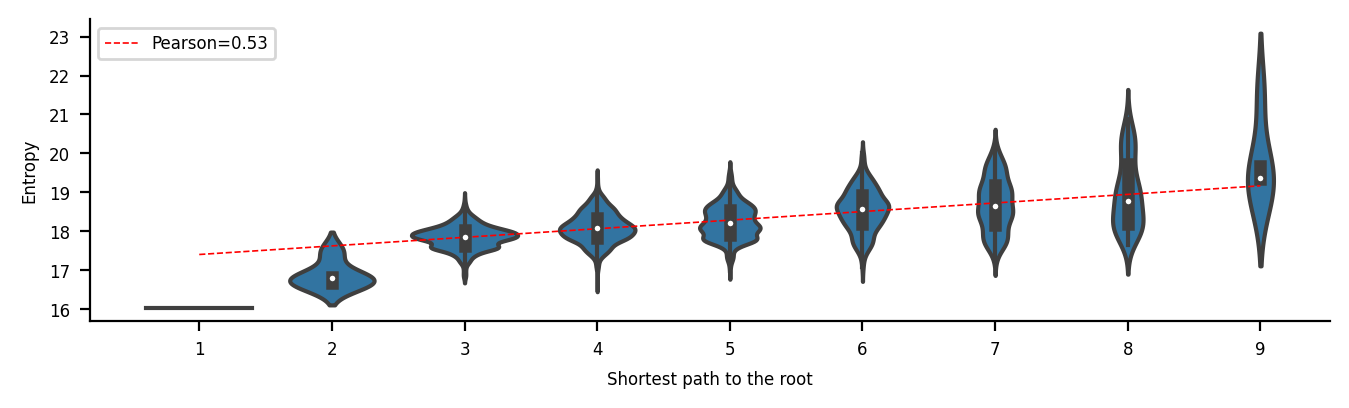

In [ ]:
#@title Plot result
fig, axs = plt.subplots(figsize=(8,2), sharey=True, dpi=200)

sns.violinplot(x="PathToRoot", 
                 y="Entropy", 
                 data=df, 
                 ax=axs, 
                 color='tab:blue')

pcor = scipy.stats.pearsonr(df.PathToRoot, df.Entropy)[0]
b, a = np.polyfit(df.PathToRoot, df.Entropy, deg=1)
xspace = np.linspace(0, df.PathToRoot.max(), num=100)
axs.plot(xspace, 
              a + b * xspace, 
              color="red",
              linestyle='--',
              lw=.6,
              label=f'Pearson={pcor:.2f}', rasterized=True)


axs.set_xticks(range(df.PathToRoot.astype(np.int32).max()+1))
axs.set_xticklabels(np.arange(df.PathToRoot.astype(np.int32).max()+1)+1)

axs.tick_params(
  axis='both', 
  which='both',
  labelsize=6)

axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)

plt.legend(loc='upper left', prop={'size': 6})
plt.xlabel('Shortest path to the root', fontsize=6)

plt.ylabel('Entropy', fontsize=6)
plt.show()

### Node depth as the number of ancestors

The results below show entropies grouped according to the number of ancestors. The higher the number of ancestors, the higher the entropies are. This tendency shows a strong linear correlation.

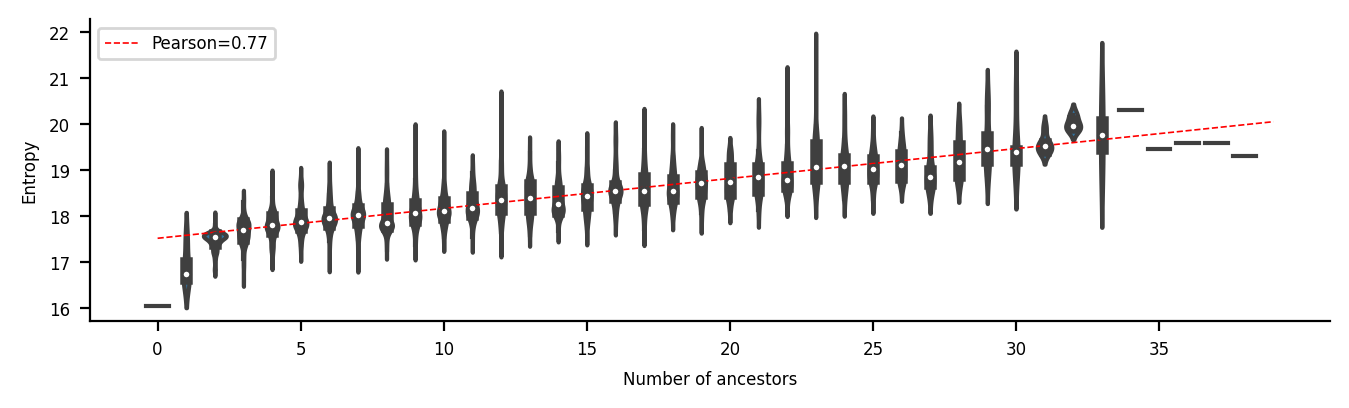

In [ ]:
#@title Plot result
fig, axs = plt.subplots(figsize=(8,2), sharey=True, dpi=200)
sns.violinplot(x="NumAncestors", 
               y="Entropy", 
               data=df, 
               ax=axs, 
               color='tab:blue')

pcor = scipy.stats.pearsonr(df.NumAncestors, df.Entropy)[0]
b, a = np.polyfit(df.NumAncestors, df.Entropy, deg=1)
xspace = np.linspace(0, df.NumAncestors.max()-1, num=100)
axs.plot(xspace, 
         a + b * xspace, 
         color="red",
         linestyle='--',
         lw=.6,
         label=f'Pearson={pcor:.2f}', rasterized=True)

xlabels = df.NumAncestors.drop_duplicates().values.astype(np.int32)
xlabels.sort()
xrng = np.arange(0, xlabels.shape[0], 5)
axs.set_xticks(xrng)
axs.set_xticklabels(xlabels[xrng], fontsize=6)

axs.tick_params(
  axis='y', 
  which='both',
  labelsize=6)

axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)

plt.xlabel('Number of ancestors', fontsize=6)
plt.ylabel('Entropy', fontsize=6)
plt.legend(loc='upper left', prop={'size': 6})
plt.show()